In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

"Marvel Characters 3.xls" gives the movie and characters in the movies, including the Phases for MCU movies
"Marvel Movies.csv" gives the movie title, release year, date, box office takings, and the Phases.  
Explanation of Phase columns:
Phase = only MCU movies (blanks = non MCU movies)
NonMCUPhase = all movies - MCU movies (0 = MCU movies, -1 is before MCU Phase 1)
PhaseF = phases for ALL movies

In [2]:
#read in datasets
marvel_char = pd.read_excel("Marvel Characters 3.xlsx")
movie_info = pd.read_csv("Marvel Movies.csv")
#split datasets into MCU and all movies (marvel_char)
MCU_char = marvel_char[marvel_char.Phase.notnull()]
marvel_char = marvel_char.iloc[:, 0:4]

#check to ensure that datasets are correct
print(MCU_char.head())
print(movie_info.head())
print(marvel_char.head())

      Movie  Year                                          Character  \
0  Iron Man  2008                              Tony Stark / Iron Man   
1  Iron Man  2008                                       Pepper Potts   
2  Iron Man  2008                        Obadiah Stane / Iron Monger   
3  Iron Man  2008                                Professor Ho Yinsen   
4  Iron Man  2008  Col. James "Rhodey" Rhodes / War Machine / Iro...   

                  Time  Phase  Time2  
0  1900-01-03 05:15:00    1.0  77.25  
1             23:15:00    1.0  23.25  
2             22:00:00    1.0  22.00  
3             10:45:00    1.0  10.75  
4             08:15:00    1.0   8.25  
                    Title  Year Opening weekend box office (million)  \
0          Captain Marvel  2019                              $153.43   
1      Ant-Man & The Wasp  2018                               $75.80   
2              Deadpool 2  2018                              $125.57   
3  Avengers: Infinity War  2018              

In [3]:
#Getting the combinations of character interactions from each movie (ALL movies)
from itertools import combinations

#We need to find the combinations of different character pairs per movie.  Hence we groupby Movie, and apply the
#combinations function, which gives a non-repeated combination of the pairs and convert it into a dataframe.
allmovies = (marvel_char.groupby('Movie')['Character'].apply(lambda x: pd.DataFrame(list(combinations(x,2))))
                                                         .reset_index(level=1, drop = True)
                                                         .reset_index())

#Rename the columns are char1 and char2
allmovies.rename(columns={0:'char1',
                       1:'char2'}, 
                 inplace=True)

#Add in phases column
#select phases from movie_info df
allmovies_phase = movie_info[['Title', 'PhaseF']]
allmovies_phase.rename(columns={'Title':'Movie'},
                                 inplace = True)
#merge movies with movie_phases
allmovies_new = pd.merge(allmovies, allmovies_phase, 
                  left_on=['Movie'],
                  right_on=['Movie'],
                  how='inner')

print(allmovies_new.head())
print(len(allmovies_new))

#split MCU into 3 different phases P1, P2, P3
am_p1 = allmovies_new.query('PhaseF <= 1')
am_p2 = allmovies_new.query('PhaseF <3')
am_p3 = allmovies_new.copy()

#Following codes to check we selected the right number of movies per phase but were not needed so commented out
# print(am_p1.head())
# print(len(am_p1))
# print(len(am_p2))
# print(len(am_p3))


     Movie                 char1                        char2  PhaseF
0  Ant-Man  Scott Lang / Ant-Man                 Dr. Hank Pym       2
1  Ant-Man  Scott Lang / Ant-Man     Hope van Dyne / The Wasp       2
2  Ant-Man  Scott Lang / Ant-Man  Darren Cross / Yellowjacket       2
3  Ant-Man  Scott Lang / Ant-Man                         Luis       2
4  Ant-Man  Scott Lang / Ant-Man                  Cassie Lang       2
7395


C:\Users\clarachua\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [4]:
#Create 3 new network graphs based on the 3 phases for ALL movies
g_amp1 = nx.from_pandas_edgelist(am_p1, 'char1', 'char2', edge_attr = 'Movie')
g_amp2 = nx.from_pandas_edgelist(am_p2, 'char1', 'char2', edge_attr = 'Movie')
g_amp3 = nx.from_pandas_edgelist(am_p3, 'char1', 'char2', edge_attr = 'Movie')

#export the network graphs to gephi
nx.write_gexf(g_amp1, "g_amp1.gexf")
nx.write_gexf(g_amp2, "g_amp2.gexf")
nx.write_gexf(g_amp3, "g_amp3.gexf")

In [16]:
#Compute degree centrality for each phase - ALL MOVIES using the suffix 'am1' for all movies phase 1, etc.
cent_am1 = nx.degree_centrality(g_amp1)
#top_am1 = sorted(set(cent_am1.values()), reverse = True)[0:20]
cent_amp1_df = pd.DataFrame.from_dict(cent_am1, orient = 'index')
cent_amp1_df.rename(columns={0:'Centrality P1'}, inplace=True)
#print(cent_amp1_df.head())

cent_am2 = nx.degree_centrality(g_amp2)
#top_am2 = sorted(set(cent_am2.values()), reverse = True)[0:10]
cent_amp2_df = pd.DataFrame.from_dict(cent_am2, orient = 'index')
cent_amp2_df.rename(columns={0:'Centrality P2'}, inplace=True)

cent_am3 = nx.degree_centrality(g_amp3)
#top_am3 = sorted(set(cent_am3.values()), reverse = True)[0:10]
cent_amp3_df = pd.DataFrame.from_dict(cent_am3, orient = 'index')
cent_amp3_df.rename(columns={0:'Centrality P3'}, inplace=True)

#Create a dataframe of all 3 centrality measures for each character and export into an excel spreadsheet
cent_all_df = pd.concat([cent_amp1_df, cent_amp2_df, cent_amp3_df], axis=1)
print(cent_all_df.head(20))
cent_all_df.to_excel('all-cent.xls')


<class 'dict'>
                                      Centrality P1  Centrality P2  \
Aaron Davis                                     NaN            NaN   
Abby Miller                                0.043189       0.031707   
Abe Brown                                       NaN            NaN   
Abigail Whistler                           0.046512       0.034146   
Abu Bakaar                                 0.036545       0.026829   
Adrian Toomes / Vulture                         NaN            NaN   
Agent Clint Barton / Hawkeye               0.093023       0.068293   
Agent Everett Ross                              NaN            NaN   
Agent James Woo                                 NaN            NaN   
Agent Jasper Sitwell                       0.093023       0.114634   
Agent Maria Hill                           0.059801       0.090244   
Agent Miller                               0.046512       0.034146   
Agent Natasha Romanoff / Black Widow       0.089701       0.065854   
Agent

C:\Users\clarachua\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [17]:
#Getting the combinations of character interactions from all MCU movies only.  Combinations and rename same as above code
from itertools import combinations

MCU = (MCU_char.groupby('Movie')['Character'].apply(lambda x: pd.DataFrame(list(combinations(x,2))))
                                                         .reset_index(level=1, drop = True)
                                                         .reset_index())
#rename column names
MCU.rename(columns={0:'char1',
                    1:'char2'}, 
                 inplace=True)

#Add in phases column
#select phases from movie_info df
MCU_phase = movie_info[['Title', 'Phase']]
MCU_phase.rename(columns={'Title':'Movie'},
                            inplace = True)
#merge MCU with MCU_phases
MCU_new = pd.merge(MCU, MCU_phase, 
                  left_on=['Movie'],
                  right_on=['Movie'],
                  how='inner')

#split MCU into 3 different phases P1, P2, P3
MCU_p1 = MCU_new.query('Phase <= 1')
MCU_p2 = MCU_new.query('Phase <3')
MCU_p3 = MCU_new.copy()
print(MCU_p1.head())


     Movie                 char1                        char2  Phase
0  Ant-Man  Scott Lang / Ant-Man                 Dr. Hank Pym      2
1  Ant-Man  Scott Lang / Ant-Man                Hope van Dyne      2
2  Ant-Man  Scott Lang / Ant-Man  Darren Cross / Yellowjacket      2
3  Ant-Man  Scott Lang / Ant-Man                         Luis      2
4  Ant-Man  Scott Lang / Ant-Man                  Cassie Lang      2
4199
                                   Movie                           char1  \
1537  Captain America: The First Avenger  Steve Rogers / Captain America   
1538  Captain America: The First Avenger  Steve Rogers / Captain America   
1539  Captain America: The First Avenger  Steve Rogers / Captain America   
1540  Captain America: The First Avenger  Steve Rogers / Captain America   
1541  Captain America: The First Avenger  Steve Rogers / Captain America   

                           char2  Phase  
1537          Agent Peggy Carter      1  
1538  Johann Schmidt / Red Skull      1 

In [18]:
#Create 3 new network graphs for ONLY MCU movies based on the 3 phases
g_mcup1 = nx.from_pandas_edgelist(MCU_p1, 'char1', 'char2', edge_attr = 'Movie')
g_mcup2 = nx.from_pandas_edgelist(MCU_p2, 'char1', 'char2', edge_attr = 'Movie')
g_mcup3 = nx.from_pandas_edgelist(MCU_p3, 'char1', 'char2', edge_attr = 'Movie')

#export the network graphs to gephi
nx.write_gexf(g_mcup1, "mcup1.gexf")
nx.write_gexf(g_mcup2, "mcup2.gexf")
nx.write_gexf(g_mcup3, "mcup3.gexf")

C:\Users\clarachua\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


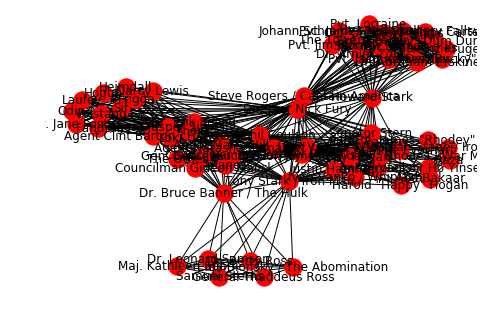

In [19]:
#plot MCU phase 1 graph in networkx with labels
nx.draw(g_mcup1, with_labels = True)

In [11]:
#Map various centrality measures for the 3 phases

cent_mcup1 = nx.degree_centrality(g_mcup1)
# print(cent_mcup1)
top_mcup1 = sorted(set(cent_mcup1.values()), reverse = True)[0:10]
cent_mcup1_df = pd.DataFrame.from_dict(cent_mcup1, orient = 'index')
# print(cent_mcup1_df)

mcup1_sorted = sorted((value, key) for (key,value) in cent_mcup1.items())
#print(type(mcup1_sorted))
print("mcu phase 1")
print(mcup1_sorted[-10:])


cent_mcup2 = nx.degree_centrality(g_mcup2)
#cent_mcup2_df = pd.DataFrame.from_dict(cent_mcup2, orient = 'index')
#print(cent_mcup2)
top_mcup2 = sorted(set(cent_mcup2.values()), reverse = True)[0:10]
#print(top_mcup2)

top_connected2 = []
for n, dc in nx.degree_centrality(g_mcup2).items():
    if dc in top_mcup2:
        top_connected2.append((n,dc))
import operator
top_connected2.sort(key = operator.itemgetter(1), reverse = True)
print("mcu phase 2")
print(top_connected2)


cent_mcup3 = nx.degree_centrality(g_mcup3)
top_mcup3 = sorted(set(cent_mcup3.values()), reverse = True)[0:10]
#print(cent_mcup3)
top_connected3 = []
for n, dc in nx.degree_centrality(g_mcup3).items():
    if dc in top_mcup3:
        top_connected3.append((n,dc))
top_connected3.sort(key = operator.itemgetter(1), reverse = True)

print("mcu phase 3")
print(top_connected3)

mcu phase 1
[(0.4375, 'Dr. Erik Selvig'), (0.4375, 'Loki'), (0.4375, 'Thor'), (0.46875, 'Howard Stark'), (0.515625, 'J.A.R.V.I.S.'), (0.515625, 'Pepper Potts'), (0.53125, 'Steve Rogers / Captain America'), (0.609375, 'Tony Stark / Iron Man'), (0.671875, 'Agent Phil Coulson'), (0.90625, 'Director Nick Fury')]
mcu phase 2
[('Steve Rogers / Captain America', 0.5845070422535211), ('Tony Stark / Iron Man', 0.528169014084507), ('Director Nick Fury', 0.528169014084507), ('J.A.R.V.I.S.', 0.4859154929577465), ('Sam Wilson / Falcon', 0.4295774647887324), ('Peggy Carter', 0.4295774647887324), ('Thanos', 0.4154929577464789), ('Thor', 0.4014084507042254), ('Dr. Erik Selvig', 0.4014084507042254), ('Heimdall', 0.35211267605633806), ('Dr. Bruce Banner / The Hulk', 0.3380281690140845), ('Natasha Romanoff / Black Widow', 0.33098591549295775), ('Baron Wolfgang von Strucker', 0.33098591549295775), ('Dr. List', 0.33098591549295775), ('Cameron Klein', 0.33098591549295775), ('Agent Jasper Sitwell', 0.3309859

In [ ]:
# #Legacy code 

# #Map centrality of characters for 3 phases, map back into df
# cent_mcu = nx.degree_centrality(g_mcu)
# top_10_mcu = sorted(set(cent_mcu.values()), reverse = True)[0:10]
# print(top_10_mcu)

# #Map betweenness of characters in g
# betw = nx.betweenness_centrality(g)
# top_10_bet = sorted(set(betw.values()), reverse = True)[0:10]
# print(top_10)

# top_betw = []
# for n, dc in nx.betweenness_centrality(g).items():
#     if dc in top_10_bet:
#         top_betw.append((n,dc))
# print(top_betw)

# #Map closeness of characters in g
# close = nx.closeness_centrality(g)
# top_10_close = sorted(set(close.values()), reverse = True)[0:10]
# print(top_10)

# top_close = []
# for n, dc in nx.closeness_centrality(g).items():
#     if dc in top_10_close:
#         top_close.append((n,dc))
# print(top_close)